# Deep Neural Network for Image Classification

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) #  plots size
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


np.random.seed(1)

### Dataset

**Постановка задачи**: вам дается набор данных ("data.h5"), содержащий:
    - обучающий набор изображений m_train, помеченных как cat (1) или non-cat (0)
    - тестовый-набор m_test изображений помечены как кошка, и не кот
    - каждое изображение имеет форму (num_px, num_px, 3), где 3-для 3 каналов (RGB).

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


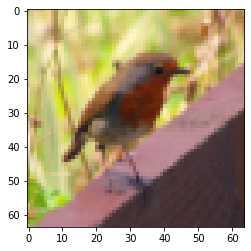

In [3]:
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
num_px = train_x_orig.shape[1]

print ("количество обучающих примеров:", train_x_orig.shape[0])
print ("количество тестовых примеров:",   test_x_orig.shape[1])
print ("каждое изображение имеет размер:", (num_px, num_px, 3))

print ("train_x_orig shape: ", train_x_orig.shape)
print ("train_y shape:",       train_y.shape)
print ("test_x_orig shape:",   test_x_orig.shape)
print ("test_y shape:",        test_y.shape)

количество обучающих примеров: 209
количество тестовых примеров: 64
каждое изображение имеет размер: (64, 64, 3)
train_x_orig shape:  (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


Как обычно, вы изменяете форму и стандартизируете изображения, прежде чем передать их в сеть. Код указан в ячейке ниже.

<img src="https://user-images.githubusercontent.com/54672403/84174090-cd01ac80-aa86-11ea-974e-bc69d2d71d57.png" style="width:450px;height:300px;">

<caption><center> Преобразование изображения в вектор.<br> </center></caption>

In [5]:
## Reshape
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T # "-1" заставляет изменить форму и сгладить остальные размеры
test_x_flatten  = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Стандартизируйте данные, чтобы они имели значения объектов от 0 до 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: ", train_x.shape)
print ("test_x's shape:  ", test_x.shape)

train_x's shape:  (12288, 209)
test_x's shape:   (12288, 50)


$12,288 $ равно $64 \times 64 \times 3$, что является размером одного измененного вектора изображения.

## Architecture of  model

Теперь, когда вы знакомы с набором данных, пришло время построить глубокую нейронную сеть, чтобы отличать изображения кошек от изображений других кошек.

Вы будете строить две разные модели:
- 2-слойная нейронная сеть
- Глубокая нейронная сеть L-слоя

Затем вы сравните производительность этих моделей, а также опробуете различные значения для $L$.

Давайте рассмотрим эти две архитектуры.


### 2-layer neural network

<img src="https://user-images.githubusercontent.com/54672403/84174552-6a5ce080-aa87-11ea-9077-d20321db0a91.png" style="width:650px;height:400px;">
<caption><center> 2-слойная нейронная сеть. <br> модель может быть обобщена следующим образом: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>


<u>подробная архитектура рисунка</u>:
- Входной сигнал представляет собой изображение (64,64,3), которое сглажено до вектора размера $(12288,1)$.
- Соответствующий вектор: $[x_0,x_1,...,x_{12287}]^T$ затем умножается на весовую матрицу $W^{[1]}$ размера $(n^{[1]}, 12288)$.
- Затем вы добавляете член смещения и берете его `relu` , чтобы получить следующий вектор$[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^т$.
- Затем вы повторяете тот же процесс.
- Вы умножаете полученный вектор на $W^{[2]}$ и добавляете свой intercept (смещение).
- Наконец, вы берете sigmoid по результату. Если он больше 0.5, вы классифицируете его как кошку.


### L-layer deep neural network

Трудно представить глубокую нейронную сеть L-слоя с вышеуказанным представлением. Однако здесь представлено упрощенное представление:
<img src="https://user-images.githubusercontent.com/54672403/84175148-3930e000-aa88-11ea-9b80-1bcacc36b2b5.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> Модель может быть обобщена следующим образом: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>подробная архитектура рисунка</u>:
- Входной сигнал представляет собой изображение (64,64,3), которое сглажено до вектора размера (12288,1).
- Соответствующий вектор: $[x_0,x_1,...,x_{12287}]^T$ затем умножается на весовую матрицу $W^{[1]}$ , а затем вы добавляете intercept $b^{[1]}$. Результат называется линейной единицей. ( linear unit )
- Далее вы берете relu линейной еденицы. Этот процесс может быть повторен несколько раз для каждого $(W^{[l]}, b^{[l]})$ в зависимости от архитектуры модели.
- Наконец, вы берете sigmoid конечную линейную единицу. Если он больше 0.5, вы классифицируете его как кошку.

### General methodology

Как обычно вы будете следовать методике глубокого обучения для построения модели:
    1. Инициализировать параметры / определения используются для отбора признаков
    2. Цикл для num_iterations:
        a. прямое распространение
        b. вычисление функции затрат
        c. обратное распространение
        д. обновление параметров (используя параметры, и Грады из сеть с обратным распространением ошибки)
    4. Используйте обученные параметры для прогнозирования меток

## Two-layer neural network

** Вопрос**: Используйте вспомогательные функции, реализованные в предыдущем задании, чтобы построить 2-слойную нейронную сеть со следующей структурой: *LINEAR -> RELU -> LINEAR -> SIGMOID*. Функции, которые вам могут понадобиться, и их входные данные являются:

```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [6]:
### КОНСТАНТЫ, ОПРЕДЕЛЯЮЩИЕ МОДЕЛЬ ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [7]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = [] # чтобы следить за стоимостью
    m = X.shape[1]  # количество примеров
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Loop (gradient descent)
    for i in range(0, num_iterations):
        '''
        Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID.
          Inputs: "X, W1, b1". 
          Output: "A1, cache1, A2, cache2".
        '''
        A1, cache1 =linear_activation_forward(X, W1, b1, activation = "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = "sigmoid")
        
        ## cost
        cost = compute_cost(A2, Y)

        ## Init backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        '''
        Backward propagation. 
          Inputs: "dA2, cache2, cache1". 
          Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        '''
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation = "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation = "relu")
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        ## Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if print_cost and i % 500 == 0:
            print(f"Cost after iteration {i}: {np.squeeze(cost):.4}")
        if print_cost and i % 50 == 0:
            costs.append(cost)
       
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693
Cost after iteration 500: 0.5158
Cost after iteration 1000: 0.3394
Cost after iteration 1500: 0.1745
Cost after iteration 2000: 0.07439


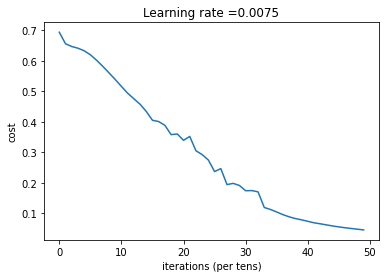

In [8]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

Хорошо, что вы построили векторизованную реализацию! В противном случае это могло бы занять в 10 раз больше времени, чтобы тренироваться.

In [9]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 100.00% 


In [10]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 72.00% 


**Примечание**: Вы можете заметить, что запуск модели на меньшем количестве итераций (скажем, 1500) дает лучшую точность в тестовом наборе. Это называется "ранняя остановка". Ранняя остановка-это способ предотвратить переобучение

## L-layer Neural Network

Используйте вспомогательные функции, реализованные ранее, чтобы построить  $L$-layer нейронную сеть уровня со следующей структурой: <bt>*[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. Функции, которые вам могут понадобиться, являются:
```python
def initialize_parameters_deep(layer_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [11]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  5-слойная модель

In [12]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Реализует L-слойной нейронной сети: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- входные дданные shape = (number of examples, num_px * num_px * 3)
    Y -- целевые переменные {0 - cat, 1 - non-cat}, shape =  (1, количество примеров)
    layers_dims -- список, содержащий входной размер и размер каждого слоя, length (number of layers + 1).
    learning_rate -- скорость обучения для обновления градиентного спуска
    num_iterations -- количество итераций цикла оптимизации
    print_cost -- если True, то он печатает cost каждые 100 шагов
    
    returns: parameters - параметры, изучаемые моделью. Затем они могут быть использованы для предсказания.
    """
    np.random.seed(1)
    costs = [] # следите за стоимостью
    
    ## init parameters
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        ## Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        ## cost
        cost = compute_cost(AL, Y)
    
        ## Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        ## Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 200 == 0:
            print(f"Cost after iteration {i}: {np.squeeze(cost):.4}")
        if print_cost and i % 50 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.7717
Cost after iteration 200: 0.6483
Cost after iteration 400: 0.567
Cost after iteration 600: 0.5279
Cost after iteration 800: 0.3691
Cost after iteration 1000: 0.3152
Cost after iteration 1200: 0.2374
Cost after iteration 1400: 0.1893
Cost after iteration 1600: 0.1482
Cost after iteration 1800: 0.1297
Cost after iteration 2000: 0.1138
Cost after iteration 2200: 0.1029
Cost after iteration 2400: 0.09288


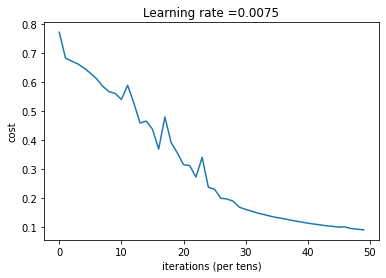

In [13]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [14]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 98.56% 


In [15]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 80.00% 


Поздравляю! Похоже, что ваша 5-слойная нейронная сеть имеет лучшую производительность (80%), чем ваша 2-слойная нейронная сеть (72%) на том же тестовом наборе.

Это хорошая производительность для этой задачи. Отличная работа!

## Results Analysis

Во-первых, давайте взглянем на некоторые изображения, которые Модель L-слоя обозначила неправильно. Это покажет несколько неверно помеченных изображений

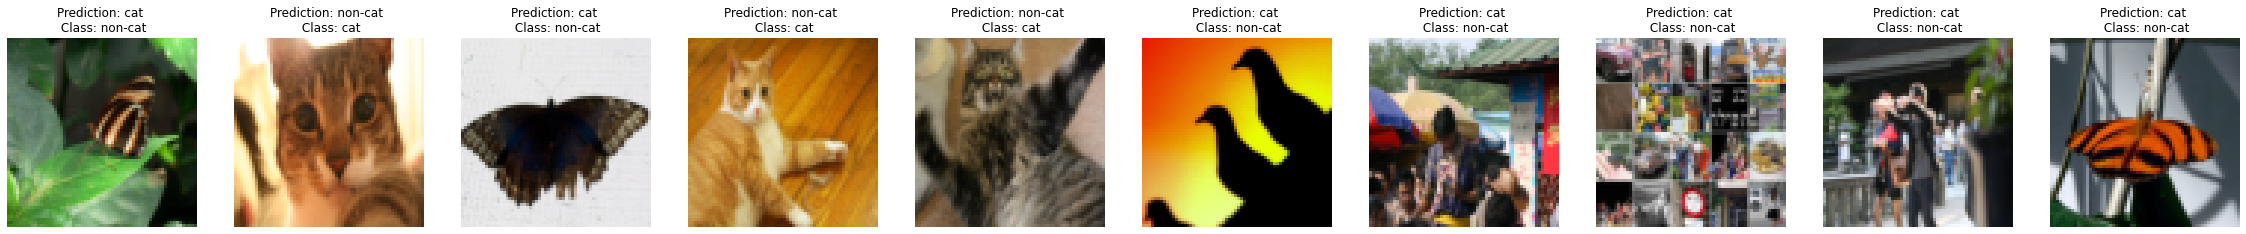

In [16]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**Несколько типов изображений, на которых модель, как правило, плохо работает, включают в себя:**
- Тело кошки в необычном положении
- Кошка появляется на фоне похожего цвета
- Необычный окрас и вид кошек
- ракурс
- Яркость изображения
- Изменение масштаба (кошка очень большая или маленькая на изображении)

my_image = "my_image.jpg"
my_label_y = [1] # класс вашего изображения (1 ~> cat, 0 ~> non-cat)

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", ваша модель L-слоя предсказывает \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")